#  Local interpretability

[Machine Learning Interpretability course](https://www.trainindata.com/p/machine-learning-interpretability)

In this notebook, we will evaluate the contribution of each feature towards the target value, for a single observation.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm

### Load data

To obtain the data, check the folder `prepare-data` in this repo, or section 2 in the course.

In [2]:
# load titanic dataset

df = pd.read_csv('../titanic.csv')

# Split the data

X_train, X_test, y_train, y_test = train_test_split(
    df.drop("survived", axis=1),
    df["survived"],
    test_size=0.15,
    random_state=1,
)

# scale the variables
scaler = StandardScaler().set_output(transform="pandas")

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [3]:
# We know from previous notebooks that these features are non-
# predictive (their coefficients are not significantly 
# different from 0.)

non_predictive = ["parch", "embarked_S", "embarked_C", "cabin_C", 
                  "cabin_B", "cabin_E", "cabin_D", "cabin_A", "cabin_G"]

# So we take them out
X_train.drop(non_predictive, axis=1, inplace=True)
X_test.drop(non_predictive, axis=1, inplace=True)

## Logistic regression

In [4]:
# Our model needs an intercept so we add a column of 1s:

X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

In [5]:
# Fit logistic regression model

logit_mod = sm.Logit(y_train, X_train)

logit_res = logit_mod.fit()

print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.478401
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:               survived   No. Observations:                 1112
Model:                          Logit   Df Residuals:                     1107
Method:                           MLE   Df Model:                            4
Date:                Tue, 14 Nov 2023   Pseudo R-squ.:                  0.2788
Time:                        10:59:39   Log-Likelihood:                -531.98
converged:                       True   LL-Null:                       -737.67
Covariance Type:            nonrobust   LLR p-value:                 9.678e-88
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6454      0.078     -8.321      0.000      -0.797      -0.493
pclass        -0.4967      0.

## Local interpretability

Let's take an individual observation and evaluate how its feature values contribute towards survival.

In [6]:
# Let's pick up a few observations

X_test.tail()

,const,pclass,sibsp,sex_female,cabin_M
401,1.0,-0.367425,0.469050,1.352596,0.539927
893,1.0,0.834271,-0.474139,-0.739319,0.539927
90,1.0,-1.569122,0.469050,1.352596,-1.852101
593,1.0,-0.367425,0.469050,1.352596,0.539927
866,1.0,0.834271,-0.474139,1.352596,0.539927


In [7]:
# We'll analize the following predictions

X_test.loc[[401, 90, 893]]

,const,pclass,sibsp,sex_female,cabin_M
401,1.0,-0.367425,0.469050,1.352596,0.539927
90,1.0,-1.569122,0.469050,1.352596,-1.852101
893,1.0,0.834271,-0.474139,-0.739319,0.539927


In [8]:
# obtain probability of survival

logit_res.get_prediction(X_test.loc[[401, 90, 893]]).summary_frame()["predicted"]

401    0.700710
90     0.903532
893    0.118756
Name: predicted, dtype: float64

First 2 passengers were likely to survive. The latter was not.

In [9]:
# check if they survived

y_test.loc[[401, 90, 893]]

401    1
90     1
893    0
Name: survived, dtype: int64

The first 2 survived, the last one did not. Model matches reality for this observations.

**Check first passenger:**

In [10]:
obs = 401

X_test.loc[obs]

const         1.000000
pclass       -0.367425
sibsp         0.469050
sex_female    1.352596
cabin_M       0.539927
Name: 401, dtype: float64

In [11]:
X_train["pclass"].unique()

array([ 0.83427143, -0.36742524, -1.56912191])

Female, second class, we don't know in which cabin she was traveling.

In [12]:
# log(Odds) contribution of each feature

effect = logit_res.params * X_test.loc[obs]
effect

const        -0.645351
pclass        0.182514
sibsp        -0.105694
sex_female    1.597413
cabin_M      -0.178203
dtype: float64

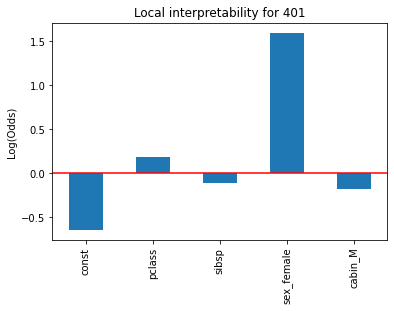

In [13]:
effect.plot.bar()

plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Log(Odds)")
plt.title(f"Local interpretability for {obs}")
plt.show()

What do we make of this plot?

- She was female, that increased her chances of survival.
- Being in second class also seemed to increase her chance of survival
- We don't have data about where she was traveling and she probably had a husband or a child, which in this data, makes her less likely to survive.

**Let's try someone else:**

In [14]:
obs = 90

X_test.loc[obs]

const         1.000000
pclass       -1.569122
sibsp         0.469050
sex_female    1.352596
cabin_M      -1.852101
Name: 90, dtype: float64

Female, first class. We have data about which cabin she was traveling.

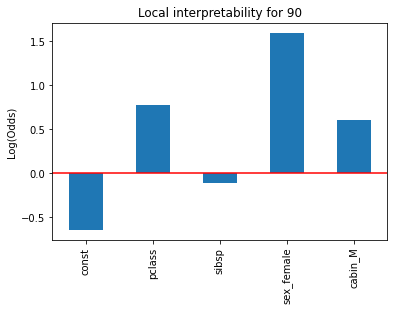

In [15]:
# log(Odds) contribution of each feature

effect = logit_res.params * X_test.loc[obs]
effect.plot.bar()

plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Log(Odds)")
plt.title(f"Local interpretability for {obs}")
plt.show()

What to make of this?

This passenger was among the most likely to survive based on our model:

- She was female
- She was rich (traveled first class)
- We know in which cabin she was traveling (not missing data)

**Let's try one more passenger:**

In [16]:
obs = 893

X_test.loc[obs]

const         1.000000
pclass        0.834271
sibsp        -0.474139
sex_female   -0.739319
cabin_M       0.539927
Name: 893, dtype: float64

Male, third class. His cabin information is missing.

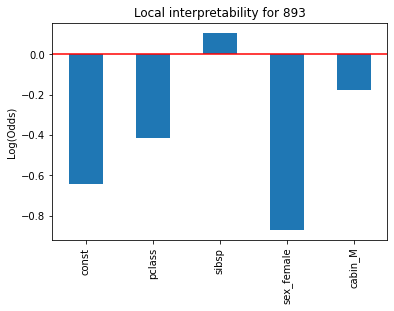

In [17]:
# log(Odds) contribution of each feature

effect = logit_res.params * X_test.loc[obs]
effect.plot.bar()

plt.axhline(y=0, color='r', linestyle='-')
plt.ylabel("Log(Odds)")
plt.title(f"Local interpretability for {obs}")
plt.show()

As expected, because he was male and poor, his chances of survival were little. The plot shows that these 2 variables are decreasing his probability of survival.